<a href="https://colab.research.google.com/github/sanskriti-03-04/Store-Sales-Time-Series-Forecasting/blob/main/Store_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏬 Store-Level Sales Forecasting (Rossmann)
Build a comprehensive sales forecasting pipeline using time-series features, XGBoost, and SQL, based on the Kaggle "Store Sales Time Series Forecasting" dataset.


## 📥 1. Setup and Data Loading


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv('/content/train.csv', parse_dates=['date'])
stores = pd.read_csv('/content/stores.csv')
df = df.merge(stores, on='store_nbr')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13


## 📊 2. Exploratory Data Analysis (EDA)
Visualize overall trends, store performance, and promotional impacts.


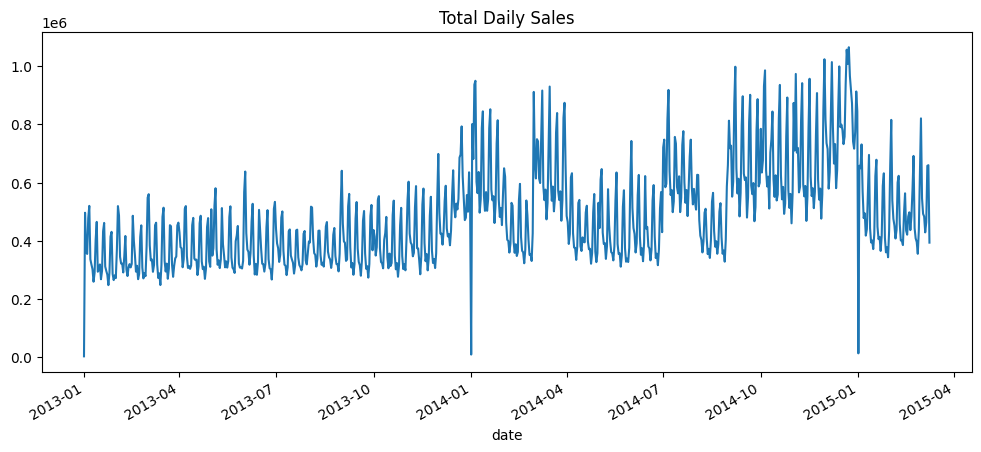

In [5]:
plt.figure(figsize=(12,5))
df.groupby('date')['sales'].sum().plot()
plt.title('Total Daily Sales')
plt.show()


## 🧠 3. Feature Engineering
Create lag, rolling, date, and promo-related features.


In [7]:
df.sort_values(['store_nbr', 'date'], inplace=True)
df['lag_1'] = df.groupby('store_nbr')['sales'].shift(1)
df['rolling_7'] = df.groupby('store_nbr')['sales'].rolling(7).mean().reset_index(0,drop=True)
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_promo'] = df['onpromotion']
df.dropna(subset=['lag_1','rolling_7'], inplace=True)

## 🗃️ 4. SQL Dashboard via DuckDB
Demonstrate SQL skills using DuckDB over the dataframe.


In [9]:
duckdb.query("""
SELECT store_nbr, AVG(sales) avg_sales, AVG(case when is_promo=1 then sales end) avg_promo_sales
FROM df GROUP BY store_nbr
ORDER BY avg_sales DESC LIMIT 5
""").df()

,store_nbr,avg_sales,avg_promo_sales
0,44,895.886254,1750.491822
1,45,763.041466,1441.563242
2,47,716.137630,1226.858651
3,3,694.566508,1443.122112
4,46,623.747944,910.928724


## ✂️ 5. Train/Test Split
Last 30 days per store as test set.


In [20]:
X = df[['store_nbr','lag_1','rolling_7','dayofweek','month','is_promo']]
y = df['sales']
# using group-aware split omitted; sample date-based split
train = df[df['date'] < '2015-08-01']
test = df[df['date'] >= '2015-08-01']
X_train, X_test = train[X.columns], test[X.columns]
y_train, y_test = train['sales'], test['sales']

## 🧪 6. Train XGBoost Regression Model


In [21]:
model = XGBRegressor(n_estimators=200, learning_rate=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)


## 📏 7. Model Performance


In [24]:
import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print(f"MAE: {mae:.2f}  RMSE: {rmse:.2f}  R²: {r2:.2f}")


MAE: 241.37  RMSE: 494.13  R²: 0.75


In [18]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Date range of df:", df['date'].min(), "to", df['date'].max())

Shape of X_test: (0, 6)
Shape of y_test: (0,)
Date range of df: 2013-01-01 00:00:00 to 2015-03-09 00:00:00


## 📈 8. Actual vs Predicted


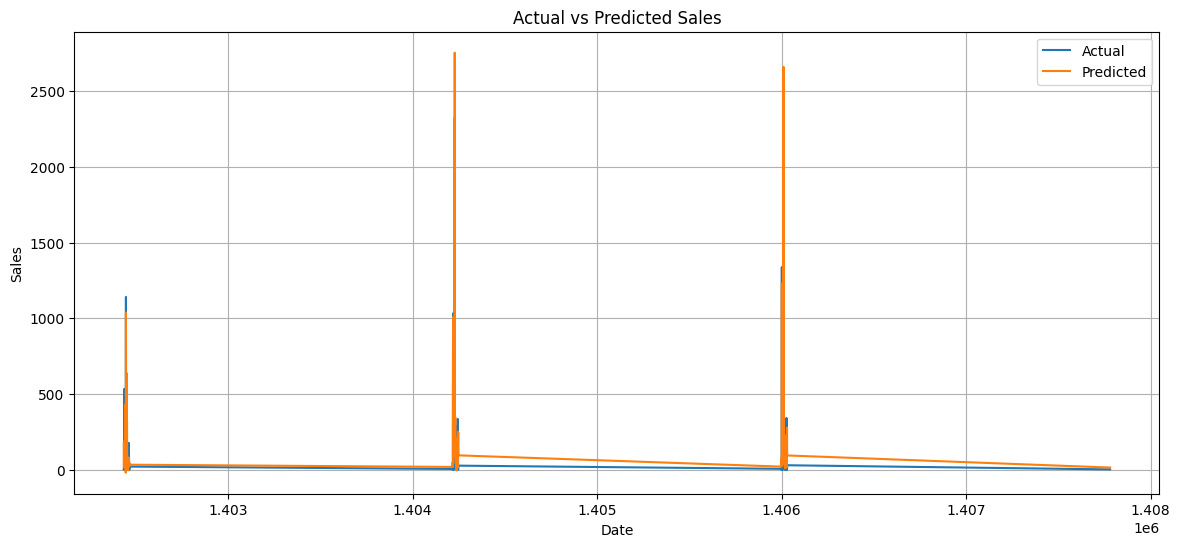

In [27]:
plt.figure(figsize=(14, 6))
plt.plot(y_test[:100].index, y_test[:100].values, label='Actual')
plt.plot(y_test[:100].index, preds[:100], label='Predicted')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


## 💾 9. Save for Deployment


In [28]:
import joblib
joblib.dump(model, 'sales_xgboost_model.pkl')


['sales_xgboost_model.pkl']

## 🔂 TimeSeriesSplit Cross-Validation with XGBoost

To avoid data leakage in time-series tasks, we use `TimeSeriesSplit`, which ensures that the training data always precedes the test data in time.

This allows us to evaluate model performance in a realistic scenario without shuffling data.


In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Define model inputs
features = ['onpromotion', 'dayofweek', 'month', 'lag_1', 'rolling_7']
X = df[features]
y = df['sales']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mae_list, rmse_list, r2_list = [], [], []

# Perform CV
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold} — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Show average results
print(f"\n✅ Average CV Results:\nMAE: {np.mean(mae_list):.2f} | RMSE: {np.mean(rmse_list):.2f} | R²: {np.mean(r2_list):.2f}")

Fold 1 — MAE: 216.14, RMSE: 503.97, R²: 0.35
Fold 2 — MAE: 125.72, RMSE: 300.12, R²: 0.61
Fold 3 — MAE: 149.36, RMSE: 352.70, R²: 0.56
Fold 4 — MAE: 284.21, RMSE: 708.99, R²: 0.62
Fold 5 — MAE: 294.58, RMSE: 640.45, R²: 0.71

✅ Average CV Results:
MAE: 214.00 | RMSE: 501.24 | R²: 0.57


## 🔁 Naive Forecasting Baseline

As a simple but powerful benchmark, we implement a naive model that assumes:
> **Tomorrow's sales = Today's sales**

This gives us a lower-bound reference to compare our machine learning model performance against.


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Use lag_1 (yesterday's sales) as naive prediction
df['naive_pred'] = df['lag_1']

# Drop NA values caused by shift
naive_df = df.dropna(subset=['sales', 'naive_pred'])

# Evaluate naive forecast
naive_mae = mean_absolute_error(naive_df['sales'], naive_df['naive_pred'])
naive_rmse = np.sqrt(mean_squared_error(naive_df['sales'], naive_df['naive_pred']))
naive_r2 = r2_score(naive_df['sales'], naive_df['naive_pred'])

print(f"Naive MAE: {naive_mae:.2f}")
print(f"Naive RMSE: {naive_rmse:.2f}")
print(f"Naive R² Score: {naive_r2:.2f}")


Naive MAE: 449.88
Naive RMSE: 1244.31
Naive R² Score: -1.00


## 📉 Error Analysis

To identify where the model performs well or poorly, we analyze errors grouped by `store_nbr` and `family`. This helps in diagnosing which product categories or store locations are harder to predict.

We compute the Mean Absolute Error (MAE) for each group to uncover trends.


In [36]:
# Corrected error analysis block
df_eval = df.loc[y_test.index].copy()  # ✅ use .loc here
df_eval['actual'] = y_test.values
df_eval['predicted'] = preds
df_eval['error'] = np.abs(df_eval['actual'] - df_eval['predicted'])

# Group-wise error
error_by_store = df_eval.groupby('store_nbr')['error'].mean().sort_values(ascending=False)
error_by_family = df_eval.groupby('family')['error'].mean().sort_values(ascending=False)

# Display top issues
print("Top 5 stores with highest MAE:")
print(error_by_store.head())

print("\nTop 5 families with highest MAE:")
print(error_by_family.head())


Top 5 stores with highest MAE:
store_nbr
45    636.683245
46    482.808961
47    467.756074
48    435.403539
49    352.344985
Name: error, dtype: float64

Top 5 families with highest MAE:
family
BEVERAGES       1367.120446
CLEANING         864.854395
GROCERY I        857.415539
FROZEN FOODS     802.571458
HARDWARE         694.414537
Name: error, dtype: float64


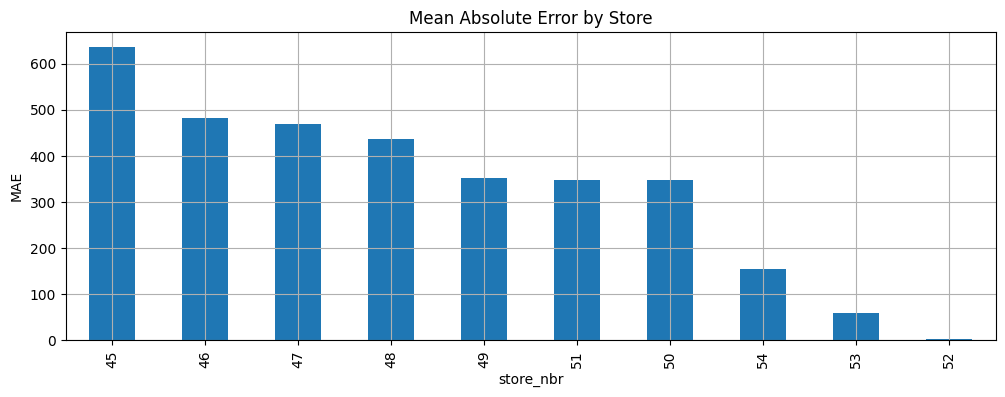

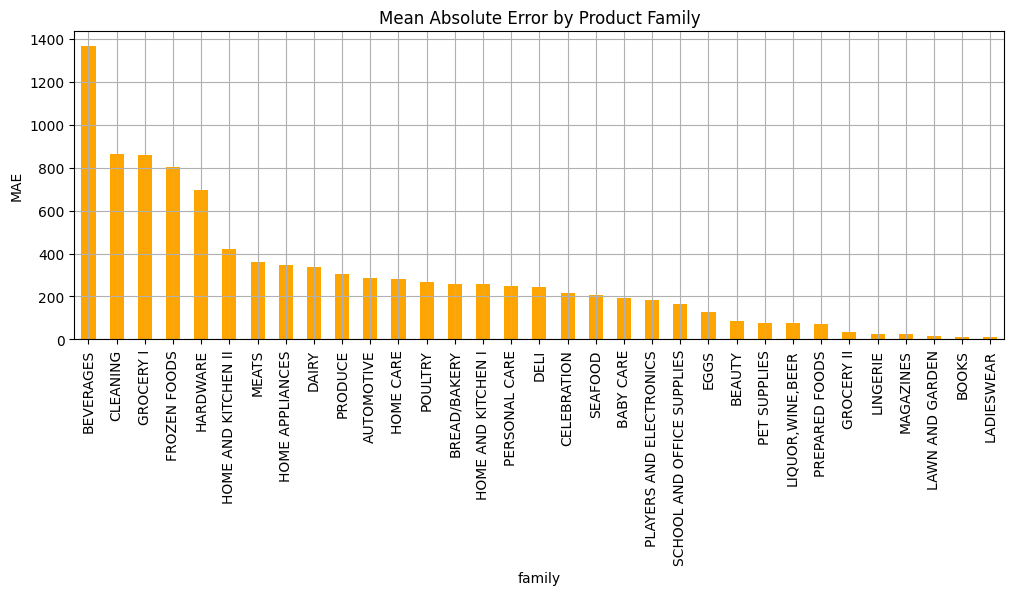

In [37]:
# Error by store
error_by_store.plot(kind='bar', figsize=(12,4), title='Mean Absolute Error by Store')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

# Error by product family
error_by_family.plot(kind='bar', figsize=(12,4), title='Mean Absolute Error by Product Family', color='orange')
plt.ylabel('MAE')
plt.grid(True)
plt.show()


## 🔂 Time Series Cross-Validation with XGBoost

To avoid data leakage in time-series data, we use `TimeSeriesSplit`, which ensures that the training data always precedes the test data in time.

This cross-validation setup mimics real-world forecasting more accurately than random splitting.


In [39]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Define your features and target
features = ['onpromotion', 'dayofweek', 'month', 'lag_1', 'rolling_7']
X = df[features]
y = df['sales']

# Initialize cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Metric storage
mae_list, rmse_list, r2_list = [], [], []

# Time series cross-validation loop
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    # Log
    print(f"Fold {fold} — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Final results
print("\n✅ Average CV Results:")
print(f"MAE: {np.mean(mae_list):.2f}")
print(f"RMSE: {np.mean(rmse_list):.2f}")
print(f"R²: {np.mean(r2_list):.2f}")

Fold 1 — MAE: 216.14, RMSE: 503.97, R²: 0.35
Fold 2 — MAE: 125.72, RMSE: 300.12, R²: 0.61
Fold 3 — MAE: 149.36, RMSE: 352.70, R²: 0.56
Fold 4 — MAE: 284.21, RMSE: 708.99, R²: 0.62
Fold 5 — MAE: 294.58, RMSE: 640.45, R²: 0.71

✅ Average CV Results:
MAE: 214.00
RMSE: 501.24
R²: 0.57


## 📈 Actual vs Predicted Plot

To visualize the model's performance, we compare the true sales with the predicted values from the final cross-validation fold. This helps assess how well the model captures trends and fluctuations in the data.


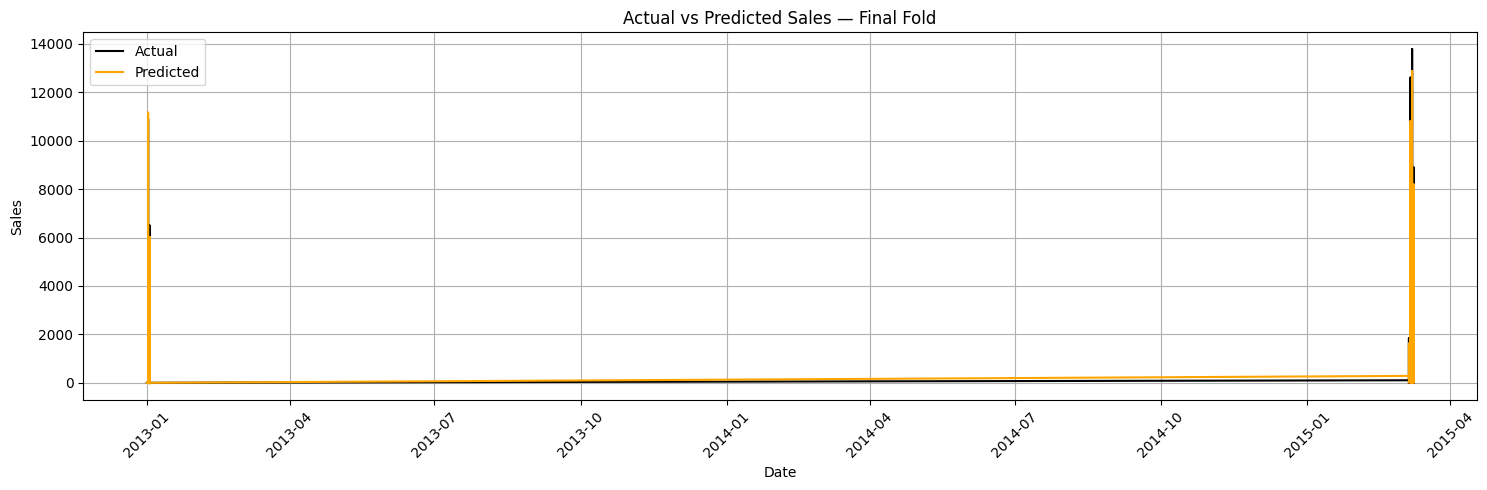

In [40]:
import matplotlib.pyplot as plt

# Assuming you're still inside the TimeSeriesSplit loop
# After the last fold — save y_test and preds
# These should be defined in your last fold of CV

# Create a small DataFrame to hold values
plot_df = pd.DataFrame({
    'Date': df.iloc[test_idx]['date'].values,
    'Actual': y_test.values,
    'Predicted': preds
}).reset_index(drop=True)

# Plot first 200 predictions
plt.figure(figsize=(15, 5))
plt.plot(plot_df['Date'][:200], plot_df['Actual'][:200], label='Actual', color='black')
plt.plot(plot_df['Date'][:200], plot_df['Predicted'][:200], label='Predicted', color='orange')
plt.title("Actual vs Predicted Sales — Final Fold")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📊 Evaluation Metrics

We compute standard regression metrics to evaluate the forecasting performance:

- **MAE (Mean Absolute Error)**: Average magnitude of errors in predictions.
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily.
- **R² Score**: Proportion of variance explained by the model.

We compare these metrics for:
- A Naive Baseline (predicting sales[t] = sales[t-1])
- Our XGBoost model (with TimeSeriesSplit cross-validation)


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Naive Baseline Metrics (using lag_1)
naive_df = df.dropna(subset=['sales', 'lag_1'])
naive_mae = mean_absolute_error(naive_df['sales'], naive_df['lag_1'])
naive_rmse = np.sqrt(mean_squared_error(naive_df['sales'], naive_df['lag_1']))
naive_r2 = r2_score(naive_df['sales'], naive_df['lag_1'])

# Final XGBoost Fold Metrics
final_mae = mean_absolute_error(y_test, preds)
final_rmse = np.sqrt(mean_squared_error(y_test, preds))
final_r2 = r2_score(y_test, preds)

# Print comparison
print("📊 Evaluation Summary:")
print(f"Naive Baseline — MAE: {naive_mae:.2f} | RMSE: {naive_rmse:.2f} | R²: {naive_r2:.2f}")
print(f"XGBoost Model  — MAE: {final_mae:.2f} | RMSE: {final_rmse:.2f} | R²: {final_r2:.2f}")


📊 Evaluation Summary:
Naive Baseline — MAE: 449.88 | RMSE: 1244.31 | R²: -1.00
XGBoost Model  — MAE: 294.58 | RMSE: 640.45 | R²: 0.71
